In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD
from fancyimpute.scaler import Scaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
import random
import itertools
from tqdm import tqdm

In [2]:
task_stats = pd.read_csv("data/task_profiles.csv")

In [3]:
task_stats["energy_consumed"] = task_stats["energy_consumed"] / 1e6
task_stats["power"] = task_stats["energy_consumed"] / task_stats["running_duration"]
task_stats["llc_misses_per_sec"] = task_stats["llc_misses"]/task_stats["running_duration"]
task_stats["instructions_per_sec"] = task_stats["instructions_retired"]/task_stats["running_duration"]
task_stats["llc_misses_per_sec"] = task_stats["llc_misses_per_sec"] / 1e6
task_stats["llc_misses"] = task_stats["llc_misses"] / 1e6
task_stats["instructions_per_sec"] = task_stats["instructions_per_sec"] / 1e8
task_stats["instructions_retired"] = task_stats["instructions_retired"] / 1e8
task_stats["core_cycles"] = task_stats["core_cycles"] / 1e8
task_stats["core_cycles_per_sec"] = task_stats["core_cycles"] / task_stats["running_duration"]
task_stats

func_name                           endpoint_id  \
0         __main__.dna_visualization  1a302149-7bef-40fe-9dc1-08ae540dc719   
1                 __main__.graph_bfs  1a302149-7bef-40fe-9dc1-08ae540dc719   
2                 __main__.graph_bfs  1a302149-7bef-40fe-9dc1-08ae540dc719   
3                 __main__.graph_bfs  1a302149-7bef-40fe-9dc1-08ae540dc719   
4                 __main__.graph_bfs  1a302149-7bef-40fe-9dc1-08ae540dc719   
..                               ...                                   ...   
952  chemfunctions._compute_vertical  6754af96-7afa-4c81-b7ef-cf54587f02fa   
953  chemfunctions._compute_vertical  6754af96-7afa-4c81-b7ef-cf54587f02fa   
954  chemfunctions._compute_vertical  6754af96-7afa-4c81-b7ef-cf54587f02fa   
955  chemfunctions._compute_vertical  6754af96-7afa-4c81-b7ef-cf54587f02fa   
956  chemfunctions._compute_vertical  6754af96-7afa-4c81-b7ef-cf54587f02fa   

     running_duration  energy_consumed  llc_misses  instructions_retired  \
0           11.210850        59.144569   20.042383           1153.485652   
1            2.378046        11.780697  103.004049             73.124488   
2            2.310476         9.688879   81.279936             64.008696   
3            2.241892        10.601009   88.578372             70.432689   
4            2.282943        11.363154   98.643937             71.331728   
..                ...              ...         ...                   ...   
952          4.585582         2.614769    4.706094              5.100097   
953          4.615035         2.622103    4.804193              5.102536   
954          4.614999         2.695268    5.387956              5.182054   
955          4.617966         2.631943    4.830346              5.120549   
956          4.612825         2.624246    4.742789              5.115839   

     core_cycles    ref_cycles     power  llc_misses_per_sec  \
0     333.149046  0.000000e+00  5.275654            1.787767   
1      60.014116  0.000000e+00  4.953940           43.314574   
2      54.816844  0.000000e+00  4.193456           35.178870   
3      55.980194  0.000000e+00  4.728600           39.510544   
4      57.379943  0.000000e+00  4.977415           43.209111   
..           ...           ...       ...                 ...   
952     8.301280  8.856441e+08  0.570215            1.026281   
953     8.224996  8.805480e+08  0.568165            1.040987   
954     8.218894  8.838076e+08  0.584023            1.167488   
955     8.381860  8.890845e+08  0.569936            1.045990   
956     8.361266  8.858850e+08  0.568902            1.028174   

     instructions_per_sec  core_cycles_per_sec  
0              102.890116            29.716663  
1               30.749821            25.236735  
2               27.703684            23.725347  
3               31.416629            24.970067  
4               31.245514            25.134198  
..                    ...                  ...  
952              1.112203             1.810300  
953              1.105633             1.782217  
954              1.122872             1.780909  
955              1.108832             1.815054  
956              1.109047             1.812613  

[957 rows x 12 columns]

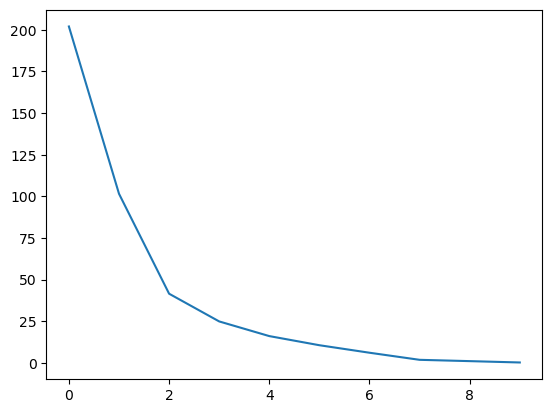

In [4]:
cross_platform_df = pd.pivot_table(task_stats, values=["llc_misses_per_sec", "instructions_per_sec", "core_cycles_per_sec"], index=["func_name"],
                       columns=["endpoint_id"], aggfunc="mean").dropna()
cross_platform_array_full = cross_platform_df.to_numpy()
U, S, Vh = np.linalg.svd(cross_platform_array_full)
plt.plot(S)

In [24]:
idx = pd.IndexSlice

def smae(preds, correct):
    return np.mean(np.abs(preds - correct)/(np.abs(preds) + np.abs(correct)))

def predict_instance(df, imputer = None, two_phase=True, joint=True):
    if imputer is None:
        imputer = KNN(k=3, normalizer=Scaler())
        
    if two_phase:
        perf_counters = df[["instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec"]]
        perf_counters_pred = imputer.fit_transform(perf_counters.values)
        df = df.fillna(pd.DataFrame(perf_counters_pred, index=perf_counters.index, columns=perf_counters.columns))
    
    if joint:
        runtime_df = df
        runtime_pred = imputer.fit_transform(runtime_df.values)
        df = df.fillna(pd.DataFrame(runtime_pred, index=runtime_df.index, columns=runtime_df.columns))
    else:
        runtime_df = df[["instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "running_duration"]]
        runtime_pred = imputer.fit_transform(runtime_df.values)
        df.loc[:, ["instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "running_duration"]] = df[["instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "running_duration"]].fillna(pd.DataFrame(runtime_pred, index=runtime_df.index, columns=runtime_df.columns))
        
        power_df = df[["instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "power"]]
        power_pred = imputer.fit_transform(power_df.values)
        df.loc[:, ["instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "power"]] = df[["instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "power"]].fillna(pd.DataFrame(power_pred, index=power_df.index, columns=power_df.columns))
    return df

def create_unmask_columns(machines, n_keep=1):
    combinations = list(itertools.combinations(machines, n_keep))
    random.shuffle(combinations)
    return combinations

def evaluate_energy_predictions(cross_platform_df, imputer=None, two_phase=True, joint=True, k=1, n_combinations=10, n_keep=1):
    endpoints = np.array(task_stats["endpoint_id"].unique())
    preds = []
    runtime_smae = []
    power_smae = []
    energy_smae = []
    unmask_columns = create_unmask_columns(endpoints, n_keep)
    for endpoint_ids in unmask_columns[:n_combinations]:
        masked_endpoints = list(set(endpoints) - set(endpoint_ids))
        for i in range(len(cross_platform_df)):
            incomplete_df = cross_platform_df.copy()
            incomplete_df.iloc[i, :] = np.NaN
            incomplete_df.loc[:, (slice(None), endpoint_ids)] = cross_platform_df.loc[:, (slice(None), endpoint_ids)]
            pred_df = predict_instance(incomplete_df, imputer, two_phase, joint)
            pred_energy_full = pred_df["running_duration"].iloc[i] * pred_df["power"].iloc[i]
            correct_energy_full = cross_platform_df["running_duration"].iloc[i] * cross_platform_df["power"].iloc[i]
            
            pred_runtime = pred_df.loc[:, ("running_duration", masked_endpoints)].iloc[i]
            correct_runtime = cross_platform_df.loc[:, ("running_duration", masked_endpoints)].iloc[i]
            pred_power = pred_df.loc[:, ("power", masked_endpoints)].iloc[i]
            correct_power = cross_platform_df.loc[:, ("power", masked_endpoints)].iloc[i]
            pred_energy = pred_energy_full.loc[masked_endpoints]
            correct_energy = correct_energy_full.loc[masked_endpoints]
            
            runtime_smae.append(smae(pred_runtime, correct_runtime))
            power_smae.append(smae(pred_power, correct_power))
            energy_smae.append(smae(pred_energy, correct_energy))
            
            correct_rankings = np.argsort(correct_energy_full)
            pred_rankings = np.argsort(pred_energy_full)
            ranked_correct = np.all(endpoints[correct_rankings][:k] == endpoints[pred_rankings][:k])
            preds.append(ranked_correct)
            

    print(f"Num correct ranking: {sum(preds)}/{len(preds)}")
    return np.mean(runtime_smae), np.mean(power_smae), np.mean(energy_smae), sum(preds)/len(preds)

In [292]:
def evaluate_dummy_prediction(cross_platform_df, k=1):
    machines = len(task_stats["endpoint_id"].unique())
    endpoints = np.array(task_stats["endpoint_id"].unique())
    preds = []
    for j in range(machines):
        for i in range(len(cross_platform_df)):
            X_test = cross_platform_df["energy_consumed"].copy().to_numpy()
            X_test = np.delete(X_test, (i), axis=0)
            avg_rankings = np.argsort(X_test).mean(axis=0)
            pred_rankings = np.argsort(avg_rankings)
            correct_rankings = np.argsort(cross_platform_df["energy_consumed"].to_numpy()[i, :])
            
            ranked_correct = np.all(endpoints[correct_rankings][:k] == endpoints[pred_rankings][:k])
            print("Correct:", correct_rankings)
            print("Predicted:", pred_rankings)
            print("--------------------------------------------")
            preds.append(ranked_correct)
            
    print(f"Num correct ranking: {sum(preds)}/{len(preds)}")
    return sum(preds)/len(preds)

In [276]:
cross_platform_df = pd.pivot_table(task_stats, values=["power", "running_duration", "instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "energy_consumed"], index=["func_name"],
                           columns=["endpoint_id"], aggfunc="mean").dropna()

total_functions = len(cross_platform_df)
nfunctions = list(range(5, total_functions+1))
nobservations = list(range(4))
accuracy = np.zeros((len(nfunctions), len(nobservations)), dtype=np.float64)
samples = 10

random.seed(0)
for i, f in enumerate(nfunctions):
    for _ in range(samples):
        cross_platform_df_sampled = cross_platform_df.iloc[random.sample(list(range(total_functions)), f),:]
        accuracy[i, 0] += evaluate_dummy_prediction(cross_platform_df_sampled)
        for j, keep in enumerate(nobservations[1:], start=1):
            _, _, _, rnk_acc = evaluate_energy_predictions(cross_platform_df_sampled, k=1, n_keep=keep)
            accuracy[i, j] += rnk_acc
accuracy /= samples

Correct: [0 3 2 1]
Predicted: [0 1 2 3]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [0 3 1 2]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [0 1 3 2]
--------------------------------------------
Correct: [0 3 2 1]
Predicted: [0 1 2 3]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [0 3 1 2]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [0 1 3 2]
--------------------------------------------
Correct: [0 3 2 1]
Predicted: [0 1 2 3]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [0 2 3 1]
-------------------------

Imputing row 1/5 with 9 missing, elapsed time: 0.001
Imputing row 1/5 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_

Imputing row 1/5 with 6 missing, elapsed time: 0.001
Imputing row 1/5 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_

Imputing row 1/5 with 6 missing, elapsed time: 0.000
Imputing row 1/5 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf5

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/5 with 9 missing, elapsed time: 0.000
Imputing row 1/5 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08a

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Num correct ranking: 7/20
Imputing row 1/5 with 6 missing, elapsed time: 0.000
Imputing row 1/5 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/5 with 3 missing, elapsed time: 0.000
Imputing row 1/5 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa  

Imputing row 1/5 with 9 missing, elapsed time: 0.001
Imputing row 1/5 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 6 missing, elapsed time: 0.000
Imputing row 1/5 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08a

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa  

Imputing row 1/5 with 9 missing, elapsed time: 0.001
Imputing row 1/5 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-4

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7

Imputing row 1/5 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1

Imputing row 1/5 with 6 missing, elapsed time: 0.000
Imputing row 1/5 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/5 with 6 missing, elapsed time: 0.000
Imputing row 1/5 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9

Imputing row 1/5 with 3 missing, elapsed time: 0.000
Imputing row 1/5 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7b

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7b

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa 

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/5 with 9 missing, elapsed time: 0.001
Imputing row 1/5 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/5 with 6 missing, elapsed time: 0.001
Imputing row 1/5 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7a

Imputing row 1/5 with 0 missing, elapsed time: 0.001
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id


Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Imputing row 1/5 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id


Imputing row 1/6 with 9 missing, elapsed time: 0.001
Imputing row 1/6 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/6 with 6 missing, elapsed time: 0.000
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 9 missing, elapsed time: 0.001
Imputing row 1/6 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea211

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 6 missing, elapsed time: 0.001
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Num correct ranking: 11/24
Correct: [3 1 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [1 3 0 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [0 3 

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540d

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae5

Imputing row 1/6 with 6 missing, elapsed time: 0.001
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Imputing row 1/6 with 3 missing, elapsed time: 0.001
Imputing row 1/6 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7be

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoin

Imputing row 1/6 with 3 missing, elapsed time: 0.000
Imputing row 1/6 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Num correct ranking: 15/36
Imputing row 1/6 with 3 missing, elapsed time: 0.000
Imputing row 1/6 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa  

Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 1 3]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 1 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 1 3]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 1 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
-------------------------

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/6 with 9 missing, elapsed time: 0.000
Imputing row 1/6 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/6 with 6 missing, elapsed time: 0.000
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/6 with 9 missing, elapsed time: 0.001
Imputing row 1/6 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Imputing row 1/6 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-

Imputing row 1/6 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c8

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-4

Imputing row 1/6 with 9 missing, elapsed time: 0.000
Imputing row 1/6 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/6 with 9 missing, elapsed time: 0.001
Imputing row 1/6 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint

Imputing row 1/6 with 0 missing, elapsed time: 0.001
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/6 with 0 missing, elapsed time: 0.000
Imputing row 1/6 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/7 with 6 missing, elapsed time: 0.000
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id


Imputing row 1/7 with 0 missing, elapsed time: 0.002
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a3

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-c

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a3

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Num correct ranking: 9/28
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
675

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af9

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/7 with 9 missing, elapsed time: 0.000
Imputing row 1/7 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/7 with 0 missing, elapsed time: 0.002
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7be

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc7

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0


Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Imputing row 1/7 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/7 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa   

Imputing row 1/7 with 3 missing, elapsed time: 0.000
Imputing row 1/7 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302

Imputing row 1/7 with 6 missing, elapsed time: 0.000
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a30214

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af

Imputing row 1/7 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81

Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [0 3 2 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [0 3 2 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [0 3 2 1]
-------------------------

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa  

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Imputing row 1/7 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a30214

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a30214

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a30214

Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540d

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Num correct ranking: 9/28
Imputing row 1/7 with 6 missing, elapsed time: 0.002
Imputing row 1/7 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac2

Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Imputing row 1/7 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a30214

Imputing row 1/7 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.001
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af

Imputing row 1/7 with 3 missing, elapsed time: 0.000
Imputing row 1/7 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoin

Imputing row 1/7 with 3 missing, elapsed time: 0.001
Imputing row 1/7 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Imputing row 1/7 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoin

Imputing row 1/8 with 9 missing, elapsed time: 0.000
Imputing row 1/8 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2


Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Correct: [2 3 0 1]
Predicted: [2 0 1 3]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 1 3]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 1 3]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 1 3]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
-------------------------

Imputing row 1/8 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/8 with 0 missing, elapsed time: 0.003
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.002
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa 

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/8 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a30214

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea2

Imputing row 1/8 with 3 missing, elapsed time: 0.000
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoin

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae5

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae5

Imputing row 1/8 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7af

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1

Imputing row 1/8 with 0 missing, elapsed time: 0.002
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa 

Imputing row 1/8 with 0 missing, elapsed time: 0.002
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id


Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/8 with 6 missing, elapsed time: 0.000
Imputing row 1/8 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a3

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c8

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a3

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/8 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/8 with 3 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54

Imputing row 1/8 with 0 missing, elapsed time: 0.002
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02f

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/8 with 6 missing, elapsed time: 0.000
Imputing row 1/8 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Num correct ranking: 24/48
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoin

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7b

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7b

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/8 with 6 missing, elapsed time: 0.000
Imputing row 1/8 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Imputing row 1/8 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
a

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540d

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-

Imputing row 1/8 with 3 missing, elapsed time: 0.000
Imputing row 1/8 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae54

Imputing row 1/8 with 0 missing, elapsed time: 0.001
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Imputing row 1/8 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-0

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/9 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c8

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-4

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/9 with 3 missing, elapsed time: 0.000
Imputing row 1/9 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Num correct ranking: 22/36
Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [0 2 3 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
-------------------------------------

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.002
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/9 with 0 missing, elapsed time: 0.002
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/9 with 9 missing, elapsed time: 0.000
Imputing row 1/9 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf5

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/9 with 6 missing, elapsed time: 0.001
Imputing row 1/9 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-0

Imputing row 1/9 with 3 missing, elapsed time: 0.001
Imputing row 1/9 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/9 with 9 missing, elapsed time: 0.000
Imputing row 1/9 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-0

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
a

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7b

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Num correct ranking: 25/54
Imputing row 1/9 with 3 missing, elapsed time: 0.001
Imputing row 1/9 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_i

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af9

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id


Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/9 with 9 missing, elapsed time: 0.001
Imputing row 1/9 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d42

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Num correct ranking: 13/36
Imputing row 1/9 with 6 missing, elapsed time: 0.000
Imputing row 1/9 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08a

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/9 with 6 missing, elapsed time: 0.000
Imputing row 1/9 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d42

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08a

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoin

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1d

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id


Imputing row 1/9 with 9 missing, elapsed time: 0.005
Imputing row 1/9 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a3021

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a3

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id


Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/9 with 6 missing, elapsed time: 0.000
Imputing row 1/9 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9d

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7be

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf545

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea211

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08a

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/9 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Num correct ranking: 11/36
Imputing row 1/9 with 6 missing, elapsed time: 0.000
Imputing row 1/9 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
67

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Num correct ranking: 22/36
Correct: [2 0 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [3 1 0 2]
P

Imputing row 1/9 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02f

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.003
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7be

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/9 with 9 missing, elapsed time: 0.000
Imputing row 1/9 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/9 with 9 missing, elapsed time: 0.000
Imputing row 1/9 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08a

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96

Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa  

Imputing row 1/9 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/9 with 0 missing, elapsed time: 0.001
Imputing row 1/9 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa   

Correct: [0 3 2 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [3 1 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 2 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
-------------------------

Imputing row 1/10 with 0 missing, elapsed time: 0.002
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_i

Imputing row 1/10 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.004
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7be

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a3

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/10 with 6 missing, elapsed time: 0.000
Imputing row 1/10 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/10 with 0 missing, elapsed time: 0.002
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-

Imputing row 1/10 with 6 missing, elapsed time: 0.001
Imputing row 1/10 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Num correct ranking: 29/60
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Imputing row 1/10 with 3 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpo

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Num correct ranking: 26/40
Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 1 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 3 1]
----------------------

Imputing row 1/10 with 9 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-c

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.003
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02f

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 6 missing, elapsed time: 0.000
Imputing row 1/10 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpo

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Correct: [2 3 0 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 1 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [0 3 2 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [2 0 3 1]
--------------------------------------------
Num correct ranking: 16/40
Imputing row 1/10 with 9 missing, elapsed time: 0.001
Imputing row 1/10 with 9 missing, elapsed time: 0.000
Correct: endpoi

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a30

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.005
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a30

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a

Imputing row 1/10 with 0 missing, elapsed time: 0.002
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Num correct ranking: 29/60
Imputing row 1/10 with 3 missing, elapsed time: 0.001
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
a

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
--------------------------------------------
Correct: [1 3 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 0 1 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 2 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [3 1 0 2]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 1 0 3]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 0 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [2 3 0 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 2 3 1]
Predicted: [2 0 3 1]
--------------------------------------------
Correct: [0 3 1 2]
Predicted: [2 3 0 1]
-------------------------

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea211

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.002
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
675

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-0

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    0
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-0

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/10 with 9 missing, elapsed time: 0.000
Imputing row 1/10 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 6 missing, elapsed time: 0.001
Imputing row 1/10 with 6 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.003
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id

Imputing row 1/10 with 0 missing, elapsed time: 0.002
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf5458

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40f

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.dna_visualization, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7be

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.002
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1

Imputing row 1/10 with 3 missing, elapsed time: 0.001
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-0

Imputing row 1/10 with 9 missing, elapsed time: 0.001
Imputing row 1/10 with 9 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: end

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7be

Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 6 missing, elapsed time: 0.003
Imputing row 1/10 with 6 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439 

Imputing row 1/10 with 3 missing, elapsed time: 0.001
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: end

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.video_processing, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.video_processing, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.cholesky_decomposition, dtype: int64
Predicted: end

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_mst, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    3
Name: __main__.compression, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.dna_visualization, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf5458

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.thumbnailer, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    2
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: chemfunctions._compute_vertical, dtype: int64
Predicted: endpoint_id
1a302149-7bef

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    2
ac25fdcf-5df3-41d4-a1d3-cea21126d439    3
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    1
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    1
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_pagerank, dtype: int64
--------------------------------------------
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.compression, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Imputing row 1/10 with 0 missing, elapsed time: 0.001
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    3
6754af96-7afa-4c81-b7ef-cf54587f02fa    0
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.graph_bfs, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    1
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    0
ef86d1de-d421-4423-9c6f-09acbfabf5b6    2
Name: __main__.graph_bfs, dtype: int64
--------------------------------------------
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Imputing row 1/10 with 3 missing, elapsed time: 0.000
Correct: endpoint_id
1a302149-7bef-40fe-9dc1-08ae540dc719    0
6754af96-7afa-4c81-b7ef-cf54587f02fa    3
ac25fdcf-5df3-41d4-a1d3-cea21126d439    2
ef86d1de-d421-4423-9c6f-09acbfabf5b6    1
Name: __main__.matrix_multiplication, dtype: int64
Predicted: endpoint_id
1a302149-7bef-40fe

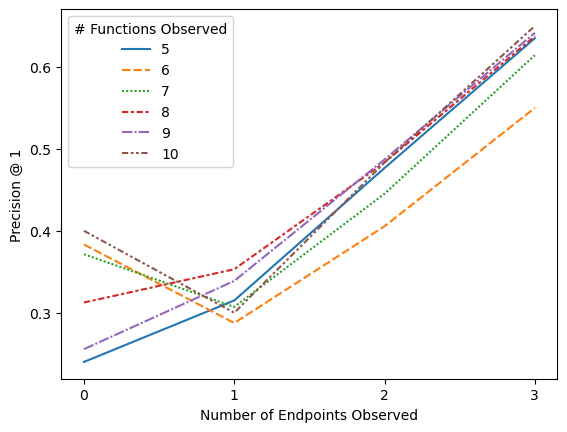

In [277]:
pred_accuracy = pd.DataFrame(accuracy.T, index=nobservations, columns=nfunctions)

fig, ax = plt.subplots()
sns.lineplot(pred_accuracy, ax=ax)

ax.set_xticks(nobservations)
ax.set_xlabel("Number of Endpoints Observed")
ax.set_ylabel("Precision @ 1")
ax.get_legend().set_title("# Functions Observed")

In [27]:
imputer_methods = {
    "KNN": KNN(k=3, normalizer=Scaler(), verbose=False),
    "NNM": NuclearNormMinimization(verbose=False),
    "SI": SoftImpute(verbose=False),
    "SVD": IterativeSVD(rank=3, verbose=False),
    "LR": IterativeImputer(estimator=LinearRegression(), min_value=0, skip_complete=True),
    "RF": IterativeImputer(estimator=RandomForestRegressor(n_estimators=10), min_value=0, skip_complete=True),
    "GBR": IterativeImputer(estimator=HistGradientBoostingRegressor(), min_value=0, skip_complete=True)
}

cross_platform_df = pd.pivot_table(task_stats, values=["power", "running_duration", "instructions_per_sec", "llc_misses_per_sec", "core_cycles_per_sec", "energy_consumed"], index=["func_name"],
                           columns=["endpoint_id"], aggfunc="mean").dropna()

results = []
for name, imputer in tqdm(imputer_methods.items()):
    for two_phase in [True, False]:
        for joint in [True, False]:
            runtime_smae, power_smae, energy_smae, p_at_1 = evaluate_energy_predictions(cross_platform_df, imputer=imputer, two_phase=two_phase, joint=joint, k=1, n_keep=1)
            results.append((name, two_phase, joint, runtime_smae, power_smae, energy_smae, p_at_1))


  0%|                                                                                                                                                                                        | 0/7 [00:00<?, ?it/s]

Num correct ranking: 12/40
Num correct ranking: 11/40
Num correct ranking: 14/40



 14%|█████████████████████████▏                                                                                                                                                      | 1/7 [00:03<00:21,  3.65s/it]

Num correct ranking: 13/40
Num correct ranking: 10/40
Num correct ranking: 8/40
Num correct ranking: 9/40



 29%|██████████████████████████████████████████████████                                                                                                                             | 2/7 [03:14<09:29, 113.90s/it]

Num correct ranking: 10/40
Num correct ranking: 10/40
Num correct ranking: 10/40
Num correct ranking: 11/40



 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 3/7 [03:20<04:17, 64.50s/it]

Num correct ranking: 11/40
Num correct ranking: 8/40
Num correct ranking: 12/40
Num correct ranking: 11/40



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 4/7 [03:46<02:27, 49.21s/it]

Num correct ranking: 9/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 5/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 8/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 6/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 10/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 11/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 14/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 7/40


/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Num correct ranking: 11/40
Num correct ranking: 12/40
Num correct ranking: 12/40
Num correct ranking: 12/40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [11:18<00:00, 96.88s/it]

Num correct ranking: 12/40


In [28]:
results = pd.DataFrame.from_records(results, columns=["strategy", "two_phase", "joint", "runtime error", "power error", "energy error", "p at 1"])
results

strategy  two_phase  joint  runtime error  power error  energy error  \
0       KNN       True   True       0.510438     0.459304      0.568258   
1       KNN       True  False       0.519048     0.484989      0.582008   
2       KNN      False   True       0.468630     0.420341      0.499261   
3       KNN      False  False       0.482964     0.442978      0.523145   
4       NNM       True   True       0.490076     0.579575      0.660915   
5       NNM       True  False       0.517539     0.630632      0.685989   
6       NNM      False   True       0.432969     0.542735      0.594198   
7       NNM      False  False       0.476507     0.580497      0.617275   
8        SI       True   True       0.472267     0.580139      0.663191   
9        SI       True  False       0.510526     0.596230      0.663450   
10       SI      False   True       0.446989     0.563891      0.627457   
11       SI      False  False       0.466734     0.555745      0.607166   
12      SVD       True   True       0.636636     0.634182      0.710931   
13      SVD       True  False       0.617646     0.655427      0.755880   
14      SVD      False   True       0.572250     0.551263      0.669536   
15      SVD      False  False       0.590376     0.484307      0.625355   
16       LR       True   True       0.629370     0.623897      0.748057   
17       LR       True  False       0.669638     0.684248      0.807085   
18       LR      False   True       0.591191     0.506557      0.659514   
19       LR      False  False       0.651582     0.656480      0.790022   
20       RF       True   True       0.469503     0.426701      0.533575   
21       RF       True  False       0.472738     0.448932      0.562090   
22       RF      False   True       0.457881     0.434437      0.521584   
23       RF      False  False       0.458056     0.433200      0.542150   
24      GBR       True   True       0.504581     0.431070      0.568559   
25      GBR       True  False       0.504581     0.431070      0.568559   
26      GBR      False   True       0.504581     0.431070      0.568559   
27      GBR      False  False       0.504581     0.431070      0.568559   

    p at 1  
0    0.300  
1    0.275  
2    0.350  
3    0.325  
4    0.250  
5    0.200  
6    0.225  
7    0.250  
8    0.250  
9    0.250  
10   0.275  
11   0.275  
12   0.200  
13   0.300  
14   0.275  
15   0.225  
16   0.125  
17   0.200  
18   0.150  
19   0.250  
20   0.275  
21   0.350  
22   0.175  
23   0.275  
24   0.300  
25   0.300  
26   0.300  
27   0.300

In [54]:
results["method"] = results["strategy"] + " " + results["joint"].astype(str)
table = pd.pivot_table(results, values=["runtime error", "energy error", "p at 1"], index=["method"],
                           columns=["two_phase"], aggfunc="mean", sort=False)
table.columns = table.columns.swaplevel(0,1)
table = table.sort_index(axis=1, level=0, sort_remaining=False)
table.sort_values(by=[(False, "p at 1")])
table = table.loc[["NNM False", "LR False", "SI False", "SVD True", "RF False", "GBR True", "GBR False", "KNN False", "KNN True"]]
table

two_phase         False                             True                     
          runtime error energy error p at 1 runtime error energy error p at 1
method                                                                       
NNM False      0.476507     0.617275  0.250      0.517539     0.685989  0.200
LR False       0.651582     0.790022  0.250      0.669638     0.807085  0.200
SI False       0.466734     0.607166  0.275      0.510526     0.663450  0.250
SVD True       0.572250     0.669536  0.275      0.636636     0.710931  0.200
RF False       0.458056     0.542150  0.275      0.472738     0.562090  0.350
GBR True       0.504581     0.568559  0.300      0.504581     0.568559  0.300
GBR False      0.504581     0.568559  0.300      0.504581     0.568559  0.300
KNN False      0.482964     0.523145  0.325      0.519048     0.582008  0.275
KNN True       0.468630     0.499261  0.350      0.510438     0.568258  0.300

In [55]:
print(table.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
two\_phase & \multicolumn{3}{l}{False} & \multicolumn{3}{l}{True} \\
{} & runtime error & energy error & p at 1 & runtime error & energy error & p at 1 \\
method    &               &              &        &               &              &        \\
\midrule
NNM False &          0.48 &         0.62 &   0.25 &          0.52 &         0.69 &   0.20 \\
LR False  &          0.65 &         0.79 &   0.25 &          0.67 &         0.81 &   0.20 \\
SI False  &          0.47 &         0.61 &   0.28 &          0.51 &         0.66 &   0.25 \\
SVD True  &          0.57 &         0.67 &   0.28 &          0.64 &         0.71 &   0.20 \\
RF False  &          0.46 &         0.54 &   0.28 &          0.47 &         0.56 &   0.35 \\
GBR True  &          0.50 &         0.57 &   0.30 &          0.50 &         0.57 &   0.30 \\
GBR False &          0.50 &         0.57 &   0.30 &          0.50 &         0.57 &   0.30 \\
KNN False &          0.48 &         0.52 &   0.33 &       

/tmp/ipykernel_1579/3491155266.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(float_format="%.2f"))
